In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib
import multiprocessing

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms.v2 as transforms
import lightning
import lightning.pytorch.callbacks as callbacks

import diffsci.models

/opt/persistence/miniconda3/envs/ddpm_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
MAINFOLDER = pathlib.Path("../..")  # This leads to the main folder
DATAFOLDER = MAINFOLDER/"saveddata"  # This leads to the data folder
MODELSFOLDER = MAINFOLDER/"savedmodels" #This leads to the models folder
EXTERNALDATAFOLDER = DATAFOLDER/'external'  # This leads to the external data folder

In [4]:
class UnlabeledMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        x, _ = self.mnist_dataset[idx]
        return x

mnist_dataset = torchvision.datasets.MNIST(EXTERNALDATAFOLDER,
                                           train=True,
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)

unlabeled_mnist_dataset = UnlabeledMNISTDataset(mnist_dataset)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 129MB/s]

Extracting ../../saveddata/external/MNIST/raw/train-images-idx3-ubyte.gz to ../../saveddata/external/MNIST/raw



Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 21.8MB/s]


Extracting ../../saveddata/external/MNIST/raw/train-labels-idx1-ubyte.gz to ../../saveddata/external/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 203MB/s]

Extracting ../../saveddata/external/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../saveddata/external/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found




100%|██████████| 4.54k/4.54k [00:00<00:00, 19.9MB/s]


Extracting ../../saveddata/external/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../saveddata/external/MNIST/raw



In [5]:
batch_size = 16
p_split = 0.8
num_workers = multiprocessing.cpu_count() - 2

num_train_dataset = int(len(unlabeled_mnist_dataset)*p_split)
num_valid_dataset = len(unlabeled_mnist_dataset) - num_train_dataset
train_dataset, val_dataset = torch.utils.data.random_split(unlabeled_mnist_dataset,
                                                           [num_train_dataset, num_valid_dataset])
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=num_workers)
val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             num_workers=num_workers)

In [6]:
modelconfig = diffsci.models.PUNetGConfig(model_channels=32, dropout=0.1)
model = diffsci.models.PUNetG(modelconfig)
config = diffsci.models.KarrasModuleConfig.from_edm(sigma_data=0.5)
module = diffsci.models.KarrasModule(model, config)

In [7]:
checkpoint_callback = callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath=MODELSFOLDER/"tutorial-0002",
    filename='sample-mnist-{epoch:02d}-{val_loss:.6f}',
    save_top_k=2,
    mode='min',
)

In [8]:
module.optimizer = torch.optim.Adam(module.parameters(),
                                    lr=2*1e-5)
module.lr_scheduler = None

In [9]:
trainer = lightning.Trainer(max_epochs=10,
                            callbacks=[checkpoint_callback])

# Train the model

# trainer.fit(model=module,
#             train_dataloaders=train_dataloader,
#             val_dataloaders=val_dataloader)

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [19]:
checkpoint_path = MAINFOLDER/\
    "savedmodels/tutorial-0002/sample-mnist-epoch=04-val_loss=0.055558.ckpt"
loaded_module = diffsci.models.KarrasModule.load_from_checkpoint(checkpoint_path, model=model, config=config)

In [20]:
samples = loaded_module.sample(nsamples=64, shape=[1, 28, 28])

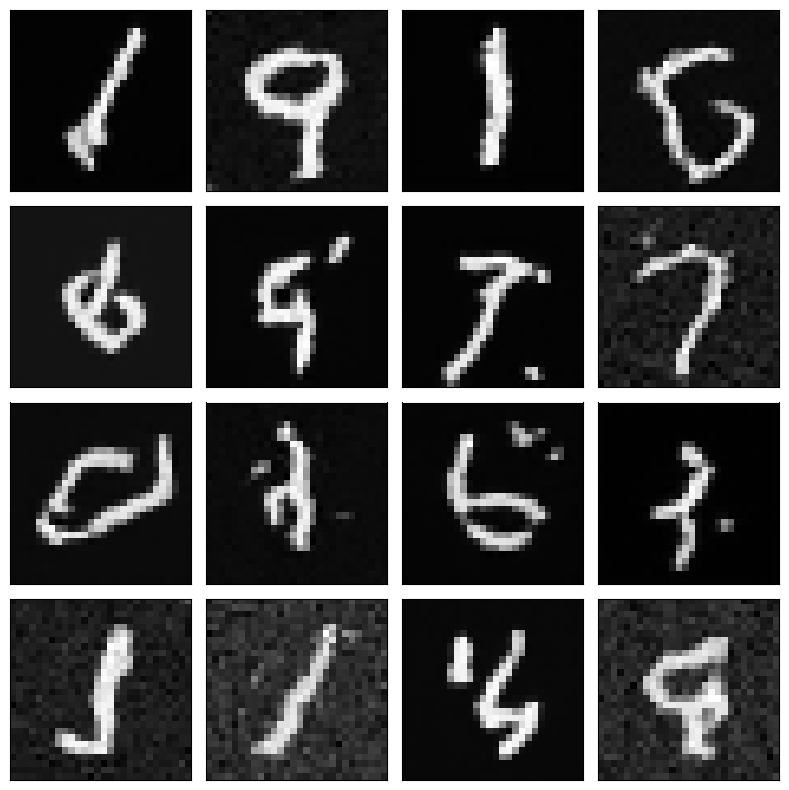

In [21]:
# Set up the matplotlib figure and axes
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    # Select the ith image from the batch
    img = samples[i].squeeze().cpu()  # Remove the channel dimension

    # Display the image
    ax.matshow(img, cmap='gray')

    # Remove axis labels
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust layout
plt.tight_layout()
plt.show()